In [4]:
import numpy as np
import csv

group_map = {}
category_map = {}

labels_path = 'data/refined_ngram_dict_labeled.csv'
with open(labels_path, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for term, _, group, category in reader:
        group_map[term] = group
        category_map[term] = category

In [5]:
import json

def aggregate_term_occurrences(path, term_map):
    result = {}
    with open(path, 'r') as f:
        for line in f:
            data = json.loads(line)
            period_key = data['_id']
            period = {}
            for term, count in data['value'].items():
                period.setdefault(term_map[term], 0)
                period[term_map[term]] += count
            result[period_key] = period
    
    return result
            
weekly_occurrences_path = 'data/phrase_occur_week.json'
group_weekly = aggregate_term_occurrences(weekly_occurrences_path, group_map)
category_weekly = aggregate_term_occurrences(weekly_occurrences_path, category_map)

In [18]:
import datetime
import obspy.signal
from scipy.signal import convolve

def generate_trends(occurx, detrend=False, smooth=4):
    timestamps = sorted(list(occurx.keys()))
    datetimes = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]
    trend_keys = list(next(iter(occurx.values())).keys())
    trends = {}
    
    for tk in trend_keys:
        trend = []        
        times = []
        for ts, dt in zip(timestamps, datetimes):
            times.append(dt)
            trend.append(occurx[ts][tk])
        
        trend = np.asarray(trend)
#         print(trend.shape)
        if detrend:
            DETREND_ORDER = 1
            trend = obspy.signal.detrend.polynomial(trend, order=DETREND_ORDER)
        if smooth:
            trend = convolve(trend, np.ones(12), 'same')[:-smooth]
            times = times[:-smooth]
#         print(trend.shape)
        trends[tk] = (times, trend)
    
    return trends

group_trends = generate_trends(group_weekly)
group_trends_detrended = generate_trends(group_weekly, detrend=True)
category_trends = generate_trends(category_weekly)
category_trends_detrended = generate_trends(category_weekly, detrend=True)

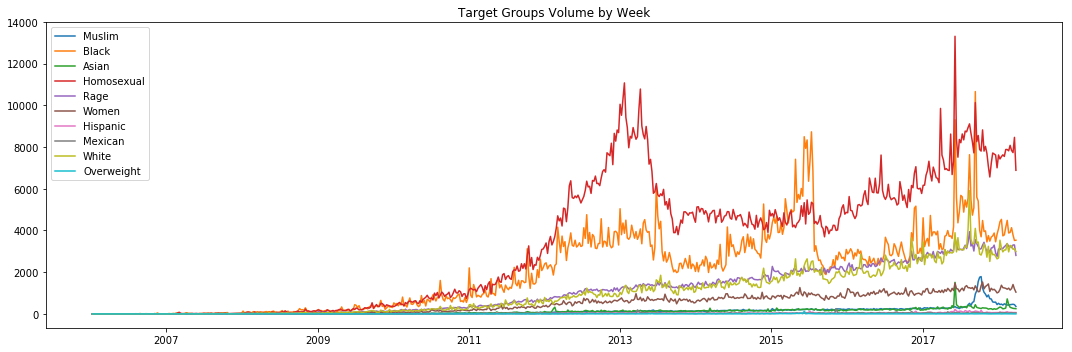

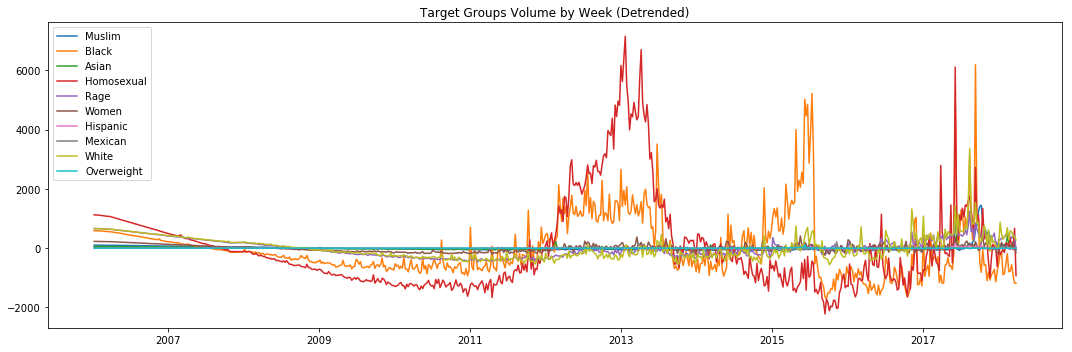

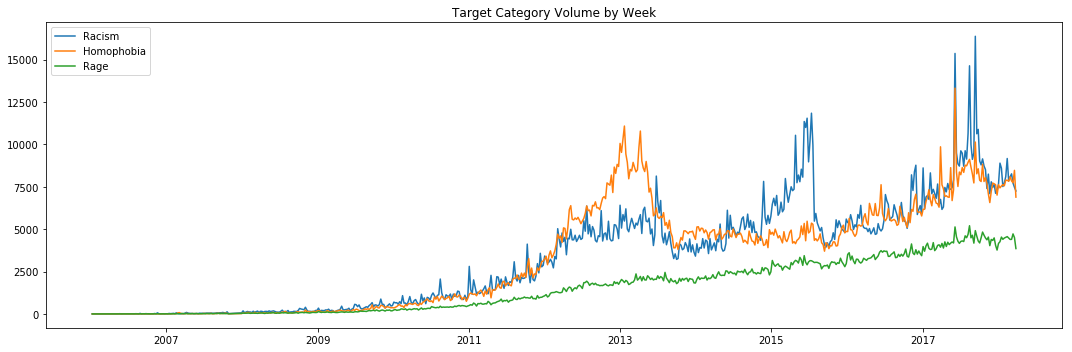

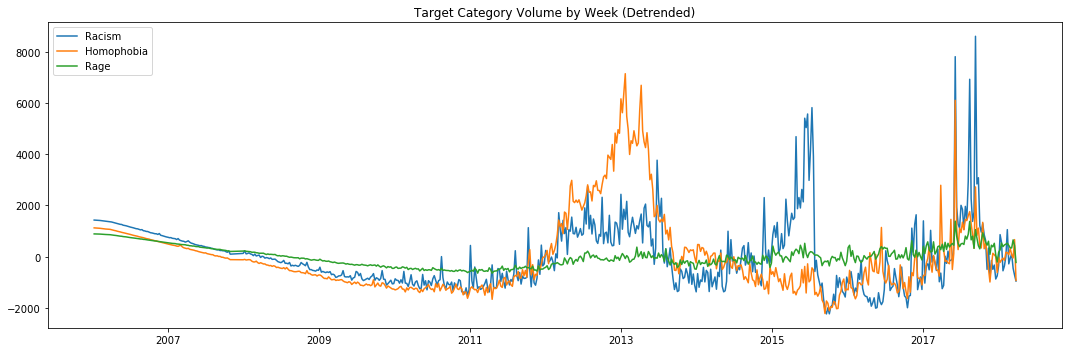

In [16]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (15, 5)

def plot_trends(trends, plot_name=None):    
    fig, ax = plt.subplots()
    
    for trend_name, data in trends.items():
        times, trend = data
        ax.plot(times, trend, label=trend_name)
    
    if plot_name is not None:
        ax.set_title(plot_name)

    fig.tight_layout()
    ax.legend()
    plt.show()
    
def plot_trend(name, data, plot_name=None):
    times, trend = data
    fig, ax = plt.subplots()
    ax.plot(times, trend, label=name)

    if plot_name is not None:
        ax.set_title(plot_name)

    fig.tight_layout()
    ax.legend()
    plt.show()
    
plot_trends(group_trends, 'Target Groups Volume by Week')
plot_trends(group_trends_detrended, 'Target Groups Volume by Week (Detrended)')
plot_trends(category_trends, 'Target Category Volume by Week')
plot_trends(category_trends_detrended, 'Target Category Volume by Week (Detrended)')

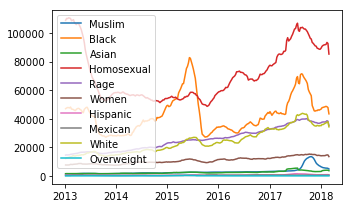

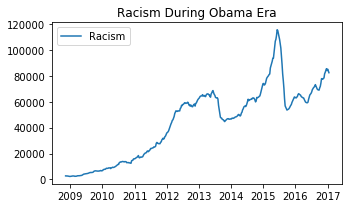

In [12]:
import numpy as np
rcParams['figure.figsize'] = (5, 3)

# For a single trend
def filter_trend(times, trend, start_date=None, end_date=None):
    timestamps = np.asarray([t.timestamp() for t in times]).reshape(-1)
    start = timestamps[0] if start_date is None else start_date.timestamp()
    end = timestamps[-1] if end_date is None else end_date.timestamp()
    date_range = np.where((timestamps >= start) & (timestamps <= end))
    def filter_arr(arr, indices):
        return [a for i,a in enumerate(arr) if i in indices[0]]
    
    return filter_arr(times, date_range), filter_arr(trend, date_range)

def filter_trends(trends, start_date=None, end_date=None):
    filtered = {}
    for tk, data in trends.items():
        filtered[tk] = filter_trend(*data, start_date, end_date)
    return filtered
    
trends_after_2013 = filter_trends(group_trends, start_date=datetime.datetime(2013,1,1))
plot_trends(trends_after_2013)
        

trends_during_obama = filter_trends(category_trends, start_date=datetime.datetime(2008,11,4), end_date=datetime.datetime(2017, 1, 20))
racism_during_obama = trends_during_obama['Racism']
plot_trend('Racism', racism_during_obama, 'Racism During Obama Era')


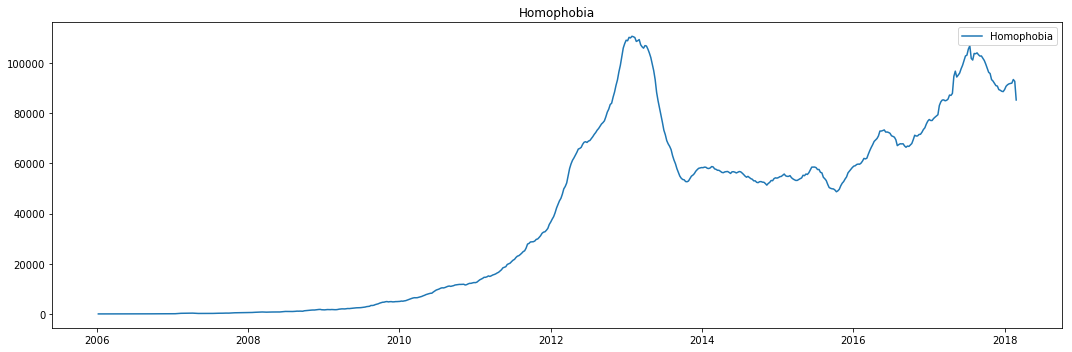

In [33]:
t = filter_trends(category_trends)['Homophobia']
plot_trend('Homophobia', t, 'Homophobia')